In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import shutil

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import NASNetMobile , VGG19
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate, LSTM, Bidirectional, Reshape, Dropout
from tensorflow.keras.models import Model

from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc

import time

from PIL import Image, ImageOps

from tensorflow.keras.preprocessing import image

import librosa
import librosa.display
from tensorflow.keras.models import load_model

import matplotlib.cm as cm

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
# Base directory where the folders are stored
image_folder = "/content/drive/MyDrive/Bird Audio Classification/birdclef_dataset/train_images"

# Mapping of classes to numerical labels
# Classes are alphabetically sorted - so we can easily restore class order when we load
class_labels = {class_name: i for i, class_name in enumerate(sorted(os.listdir(image_folder)))}
num_classes = len(class_labels)

# Collect all file paths and their corresponding class labels
file_paths = []
labels = []

# New structure to keep track of groups
samples = {}

for class_name in os.listdir(image_folder):
    class_dir = os.path.join(image_folder, class_name)
    for filename in os.listdir(class_dir):
        # Extract base sample name from filename (files split at "_")
        sample_base = filename.split('_')[0]
        full_path = os.path.join(class_dir, filename)

        if sample_base not in samples:
            samples[sample_base] = {'files': [], 'label': class_labels[class_name]}
        samples[sample_base]['files'].append(full_path)

In [ ]:
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_contrast(img, lower=0.2, upper=1.8)
    img = tf.image.random_brightness(img, max_delta=0.2)

    #scale 0-1
    img = tf.cast(img, tf.float32) / 255.0

    label = tf.one_hot(label, depth=num_classes)
    return img, label

In [ ]:
test_size = 0.2
batch_size = 32


samples_list = list(samples.items())


train_samples, val_samples = train_test_split(samples_list, test_size=test_size, random_state=42)


def extract_files_and_labels(sample_list):
    file_paths = []
    labels = []
    for _, sample_info in sample_list:
        file_paths.extend(sample_info['files'])
        labels.extend([sample_info['label']] * len(sample_info['files']))
    return file_paths, labels

train_files, train_labels = extract_files_and_labels(train_samples)
val_files, val_labels = extract_files_and_labels(val_samples)

num_classes = np.max(train_labels) + 1

#tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
#MobileNetV2 ваги з imagenet
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)

# FC слой
x = Dense(1024, activation='relu')(x)

# вихід слоя -> клас
predictions = Dense(num_classes, activation='softmax')(x)

# Lr
initial_learning_rate = 0.00005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
import keras

In [ ]:
EPOCHS = 25
checkpoint_filepath = '/content/drive/MyDrive/Bird Audio Classification/birdclef_dataset/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model is saved at the end of every epoch, if it's the best seen so far.
model.fit(train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset, callbacks=[model_checkpoint_callback])

In [ ]:
#!pip install --upgrade tensorflow

#import tensorflow as tf



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

ImportError: cannot import name 'cond' from 'keras.src.backend' (/usr/local/lib/python3.10/dist-packages/keras/src/backend.py)

In [ ]:

model_path = '/content/drive/MyDrive/Bird Audio Classification/birdclef_dataset/Model-MobileNetV2/birdclef2024_imagenet.keras'

new_model = tf.keras.models.load_model(model_path)

In [ ]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 11,200,611 (42.73 MB)

 Trainable params: 3,722,166 (14.20 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 7,444,333 (28.40 MB)

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 182), dtype=tf.float32, name=None))>

In [ ]:
# Get predictions on validation data
val_predictions = new_model.predict(val_dataset)

# Convert tensors to numpy arrays
val_labels_np = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

91/91 ━━━━━━━━━━━━━━━━━━━━ 730s 8s/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming val_labels_np and val_predictions are your validation labels and predictions respectively
# Convert the predicted probabilities to class labels by taking the argmax along axis 1
predicted_classes = val_predictions.argmax(axis=1)

# Convert one-hot encoded labels to class labels by taking the argmax along axis 1
true_classes = val_labels_np.argmax(axis=1)

# Compute accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(true_classes, predicted_classes, average='weighted')
print("Precision:", precision)

# Compute recall
recall = recall_score(true_classes, predicted_classes, average='weighted')
print("Recall:", recall)

# Compute F1-score
f1 = f1_score(true_classes, predicted_classes, average='weighted')
print("F1-score:", f1)

Accuracy: 0.8705310656022215
Precision: 0.8871885609411061
Recall: 0.8705310656022215
F1-score: 0.8697902666857121


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes, predicted_classes,normalize='true',labels=np.arange(182))
conf_matrix= pd.DataFrame(cm,columns=None)
conf_matrix.to_csv(r'confusion_matrix.csv', index = False)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

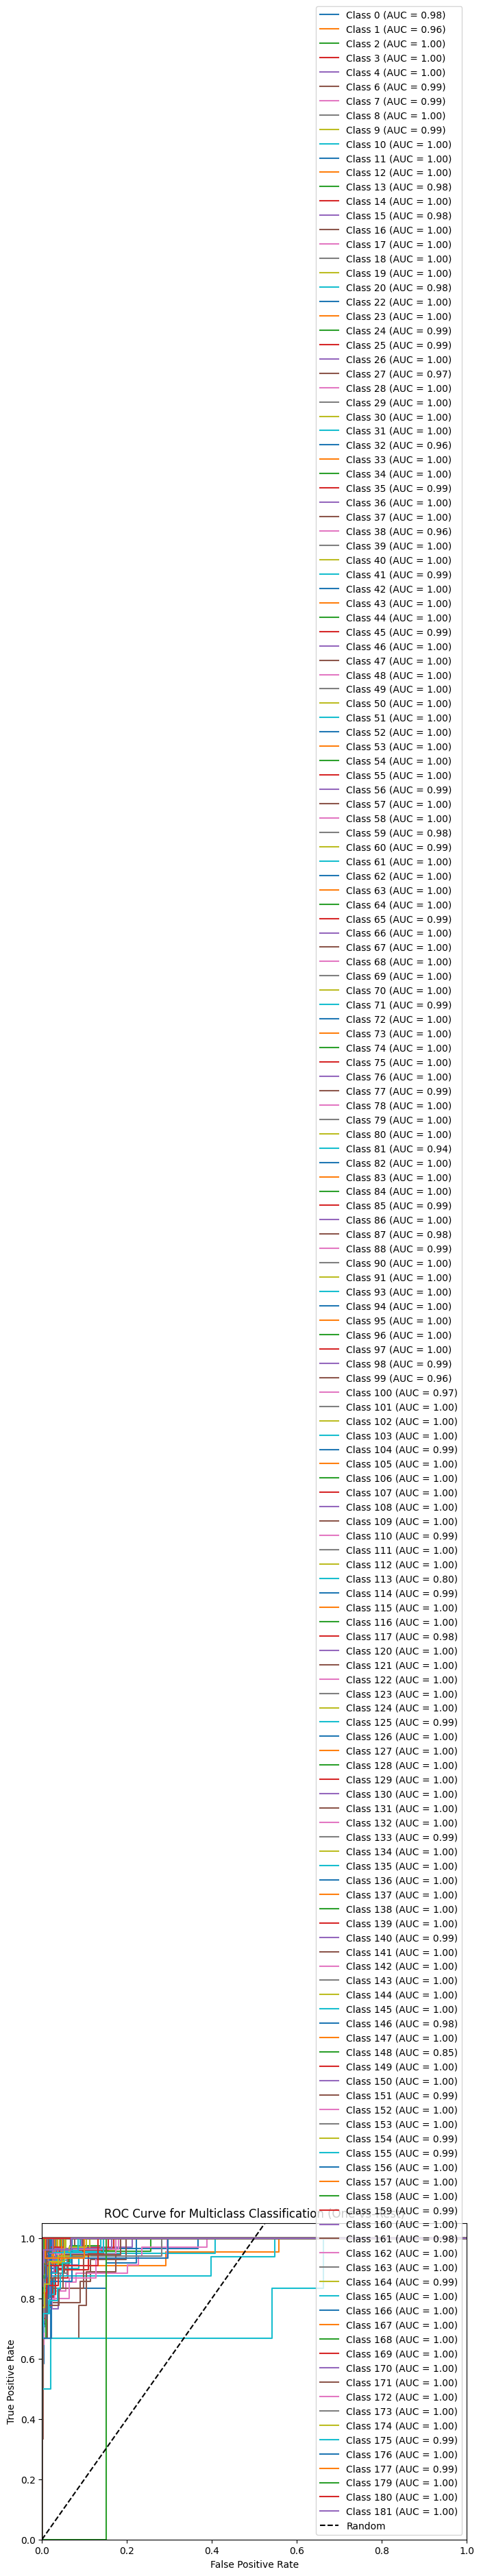

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming val_labels_np and val_predictions are your validation labels and predictions respectively
# Convert the one-hot encoded labels to binary format
true_labels = np.argmax(val_labels_np, axis=1)
# Binarize the true labels
true_labels_binarized = label_binarize(true_labels, classes=np.arange(182))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(182):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], val_predictions[:, i])
    if np.sum(true_labels_binarized[:, i]) > 0:  # Check if there are positive samples for the class
        roc_auc[i] = auc(fpr[i], tpr[i])


# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(182):
    if i in roc_auc:  # Plot only if ROC AUC score is available
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 2], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# mean ROC/AUC
mean_roc_auc = np.mean(list(roc_auc.values()))
print("Mean ROC/AUC Score:", mean_roc_auc)

Mean ROC/AUC Score: 0.9935282559902313


In [ ]:
from pandas import DataFrame
C = {
     'test accuracy': [accuracy],
     'precision': [precision],
     'recall': [recall],
     'f1-score': [f1],
     'Mean ROC/AUC Score': [mean_roc_auc]
}

# Create DataFrame
df = DataFrame(C, columns=['test accuracy', 'precision', 'recall', 'f1-score', 'Mean ROC/AUC Score'])

# Setting display option for decimal places in pandas for display purposes
pd.set_option('display.float_format', '{:.5f}'.format)

# Print DataFrame to check the formatting
print(df)

# Export to CSV with the desired float precision
df.to_csv(r'result2.csv', index=None, header=True, float_format='%.5f')

   test accuracy  precision  recall  f1-score  Mean ROC/AUC Score
0        0.87053    0.88719 0.87053   0.86979             0.99353


In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(TPR)
print(FPR)


<ipython-input-54-da1a5704699e>:12: RuntimeWarning: invalid value encountered in divide
  TPR = TP/(TP+FN)


array([0.71428571, 0.90909091, 0.87096774, 1.        , 0.94444444,
              nan, 0.8       , 0.8125    , 0.83333333, 0.76923077,
       1.        , 1.        , 1.        , 0.65217391, 0.88461538,
       0.5       , 1.        , 0.92857143, 0.7826087 , 0.91666667,
       0.85      ,        nan, 1.        , 1.        , 0.82051282,
       0.73333333, 1.        , 0.5       , 1.        , 0.625     ,
       1.        , 1.        , 0.5       , 0.89473684, 0.75      ,
       0.90322581, 1.        , 0.8125    , 0.58823529, 0.875     ,
       1.        , 0.81481481, 0.9375    , 1.        , 0.88235294,
       0.75      , 1.        , 1.        , 0.96153846, 1.        ,
       0.84210526, 1.        , 1.        , 0.90909091, 1.        ,
       1.        , 0.75      , 1.        , 0.91304348, 0.88235294,
       0.76470588, 0.82608696, 1.        , 1.        , 1.        ,
       0.8       , 0.89655172, 1.        , 1.        , 1.        ,
       0.8       , 0.95652174, 0.7       , 0.88235294, 1.     

In [ ]:
from pandas import DataFrame
C = {
     'True Positive Rate': TPR,
     'False Positive Rate': FPR}
df = DataFrame(C, columns= ['True Positive Rate','False Positive Rate'])
export_csv = df.to_csv (r'result1.csv', index = None, header=True)
print (df)

     True Positive Rate  False Positive Rate
0               0.71429              0.00036
1               0.90909              0.00076
2               0.87097              0.00095
3               1.00000              0.00029
4               0.94444              0.00017
..                  ...                  ...
177             0.86667              0.00034
178                 NaN              0.00000
179             0.86667              0.00131
180             1.00000              0.00000
181             0.80000              0.00000

[182 rows x 2 columns]


Put to Drive Folder

In [ ]:
import os
import shutil

def create_directory(directory_path):
    """
    Creates a new directory if it does not already exist.
    """
    try:
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
            print(f"Directory created at: {directory_path}")
        else:
            print(f"Directory already exists at: {directory_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

def add_file_to_directory(file_path, directory_path):
    """
    Moves a file to the specified directory.
    """
    try:
        # Construct the destination file path
        base_filename = os.path.basename(file_path)
        destination_path = os.path.join(directory_path, base_filename)

        # Move the file
        shutil.move(file_path, destination_path)
        print(f"File moved to {destination_path}")
    except FileNotFoundError:
        print(f"No such file: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


dir_path = '/content/drive/MyDrive/Bird Audio Classification/MobileNetV2'
create_directory(dir_path )
file_path = '/content/confusion_matrix.csv'
add_file_to_directory(file_path, dir_path)



Directory created at: /content/drive/MyDrive/Bird Audio Classification/MobileNetV2
File moved to /content/drive/MyDrive/Bird Audio Classification/MobileNetV2/confusion_matrix.csv


In [ ]:
file_path = '/content/result1.csv'
add_file_to_directory(file_path, dir_path)
file_path = '/content/result2.csv'
add_file_to_directory(file_path, dir_path)

File moved to /content/drive/MyDrive/Bird Audio Classification/MobileNetV2/result1.csv
File moved to /content/drive/MyDrive/Bird Audio Classification/MobileNetV2/result2.csv
